In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score
from skorch import NeuralNetClassifier
from torchvision.datasets import MNIST
import torchvision.datasets.utils as utils
import time

In [9]:
transformation= transforms.Compose([
    transforms.RandomAutocontrast(0.35),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])

In [10]:
train_data= MNIST(root='./DSE316', train= True, download= True, transform= transformation)

100%|█████████████████████████████| 9912422/9912422 [00:20<00:00, 472540.86it/s]


Extracting ./DSE316/MNIST/raw/train-images-idx3-ubyte.gz to ./DSE316/MNIST/raw



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 154237.54it/s]


Extracting ./DSE316/MNIST/raw/train-labels-idx1-ubyte.gz to ./DSE316/MNIST/raw



100%|█████████████████████████████| 1648877/1648877 [00:04<00:00, 394468.36it/s]


Extracting ./DSE316/MNIST/raw/t10k-images-idx3-ubyte.gz to ./DSE316/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 4146828.20it/s]

Extracting ./DSE316/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./DSE316/MNIST/raw



In [11]:
test_data= MNIST(root='./DSE316', train= False, download= True, transform= transformation)

In [12]:
y_train= np.array([y for x, y in iter(train_data)])
y_test= np.array([y for x, y in iter(test_data)])
x_train= np.array([x for x,y in iter(train_data)])
x_test= np.array([x for x,y in iter(test_data)])

/var/folders/z6/hycyj3yn4nb2bmr3d_s875200000gn/T/ipykernel_4968/1634495428.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x_train= np.array([x for x,y in iter(train_data)])
/var/folders/z6/hycyj3yn4nb2bmr3d_s875200000gn/T/ipykernel_4968/1634495428.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train= np.array([x for x,y in iter(train_data)])
/var/folders

In [17]:
class Model(nn.Module):
    def __init__(self, hidden_size=128, in_dims=784,  num_classes=10):
      super(Model, self).__init__()
      self.fc1= nn.Linear(in_dims, hidden_size)
      self.fc2= nn.Linear(hidden_size, hidden_size)
      self.fc3= nn.Linear(hidden_size, num_classes)
    def forward(self,x):
      x= F.relu(self.fc1(x))
      x= F.relu(self.fc2(x))
      x= self.fc3(x)

      return x

In [18]:
model= NeuralNetClassifier(
    module= Model,
    criterion= nn.CrossEntropyLoss(),
    device= 'cuda' if torch.cuda.is_available() else 'cpu',
    optimizer= optim.Adam
)

In [19]:
param_grid = {
    'module__hidden_size': [128],
    'batch_size': [32],
    'max_epochs': [5],
    'optimizer__lr': [0.001]
}


In [20]:
grid= GridSearchCV(estimator= model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_res= grid.fit(x_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4109       0.9295        0.2322  2.4934
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3926       0.9310        0.2276  2.0337
      2        0.1709       0.9511        0.1687  2.4249
      2        0.1653       0.9511        0.1627  2.0858
      3        0.1139       0.9594        0.1396  2.2141
      3        0.1113       0.9544        0.1565  2.4045
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3964       0.9041        0.3100  2.1844
      4        0.0796       0.9543        0.1554  2.5899
      4        0.0783       0.9617        0.1351  2.3647
      2        0.1644       0.9430        0.1980  2.1728
      5        0.0581       0.9567        0.1601  2.1355
      3        0.1111       0.9

In [21]:
print('Best score:', grid_res.best_score_)
print('Best params:', grid_res.best_params_)

Best score: 0.96125
Best params: {'batch_size': 32, 'max_epochs': 5, 'module__hidden_size': 128, 'optimizer__lr': 0.001}


In [22]:
model= Model(hidden_size=256)
t_split, v_split= train_test_split(train_data, test_size=0.30, random_state=2)
train_loader= DataLoader(t_split, batch_size=32)
val_loader= DataLoader(v_split, batch_size=32)
test_loader= DataLoader(test_data, batch_size=32)
lr=0.001
epochs= 5
device = torch.device('cpu')
labels= ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [23]:
loss_fun= nn.CrossEntropyLoss()
optimizer= optim.Adam(params=model.parameters(), lr=lr)
train_losses=[]
train_accs=[]
val_losses=[]
val_accs=[]
model.to(device)

Model(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [24]:
for epoch in range(epochs):

    #Training
    model.train()
    tot_train_loss=0
    train_correct=0
    train_tot=0

    tick= time.time()

    for batch_id, (imgs, labels) in enumerate(train_loader):
        #Sending the data to the device
        imgs=imgs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        #Fwd Pass
        out=model(imgs)
        loss=loss_fun(out,labels)

        #Bwd Pass
        loss.backward()
        optimizer.step()

        tot_train_loss+=loss.item()*imgs.size(0)

        x,pred=torch.max(out,1)
        train_correct+=(pred==labels).sum().item()
        train_tot+=labels.size(0)

    train_loss= tot_train_loss/len(train_loader.dataset)
    train_acc= train_correct/train_tot
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #Validation
    model.eval()
    tot_val_loss=0
    val_correct=0
    val_tot=0

    with torch.no_grad():
        for val_imgs, val_labels in val_loader:
            val_imgs=val_imgs.to(device)
            val_labels=val_labels.to(device)

            val_out=model(val_imgs)
            vloss= loss_fun(val_out,val_labels)
            tot_val_loss+=vloss.item()*val_imgs.size(0)

            _, val_pred= torch.max(val_out,1)
            val_correct+=(val_pred==val_labels).sum().item()
            val_tot+=val_labels.size(0)

    val_loss= tot_val_loss/len(val_loader.dataset)
    val_acc= val_correct/val_tot
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    tock=time.time()
    tot_time=tock-tick

    print(f'Epoch:{epoch+1}\t Train_Loss: {train_loss:.4f}\t Val_Loss: {val_loss:.4f}\t Train_Acc: {train_acc:.4f}\t Val_Acc: {val_acc:.4f}\t Time: {tot_time:.2f} seconds')

Epoch:1	 Train_Loss: 0.2689	 Val_Loss: 0.1467	 Train_Acc: 0.9196	 Val_Acc: 0.9548	 Time: 8.28 seconds
Epoch:2	 Train_Loss: 0.1084	 Val_Loss: 0.1324	 Train_Acc: 0.9674	 Val_Acc: 0.9586	 Time: 6.49 seconds
Epoch:3	 Train_Loss: 0.0707	 Val_Loss: 0.1097	 Train_Acc: 0.9787	 Val_Acc: 0.9678	 Time: 6.84 seconds
Epoch:4	 Train_Loss: 0.0489	 Val_Loss: 0.1081	 Train_Acc: 0.9855	 Val_Acc: 0.9683	 Time: 6.42 seconds
Epoch:5	 Train_Loss: 0.0384	 Val_Loss: 0.1277	 Train_Acc: 0.9875	 Val_Acc: 0.9674	 Time: 6.08 seconds


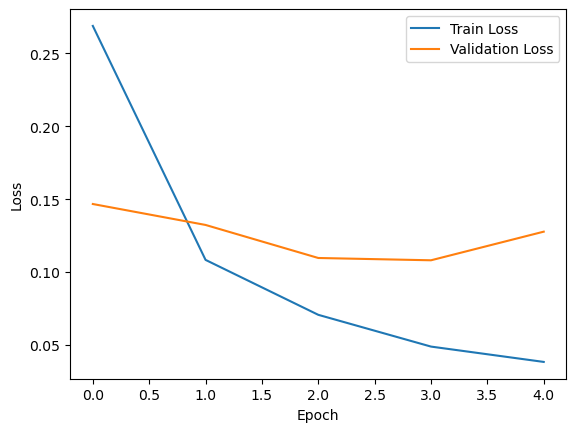

In [25]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

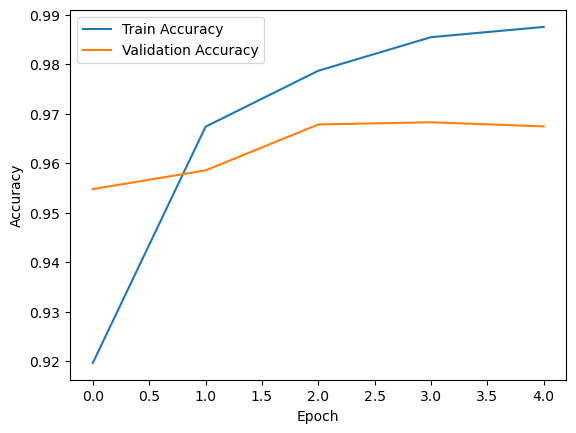

In [26]:
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
def eval_model(model, data, class_labels):
    model.eval()
    all_labels=[]
    preds=[]

    with torch.no_grad():
        for imgs, labels in data:
            imgs= imgs.to(device)
            labels=labels.to(device)
            out=model(imgs)
            _, pred= torch.max(out,1)

            all_labels.extend(labels.cpu().numpy())
            preds.extend(pred.cpu().numpy())

    print('Classification Report:')
    print(classification_report(all_labels,preds, target_names=class_labels))

    print('Confusion Matrix:')
    cm=confusion_matrix(all_labels,preds)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot()
    plt.tight_layout()
    disp.ax_.set_xticklabels(labels= class_labels, rotation=90)
    plt.show()

Classification Report:
              precision    recall  f1-score   support

       plane       0.99      0.97      0.98       980
         car       0.98      0.99      0.99      1135
        bird       0.99      0.90      0.94      1032
         cat       0.90      0.98      0.94      1010
        deer       0.96      0.99      0.97       982
         dog       0.96      0.98      0.97       892
        frog       0.99      0.97      0.98       958
       horse       0.99      0.93      0.96      1028
        ship       0.96      0.97      0.96       974
       truck       0.95      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Confusion Matrix:


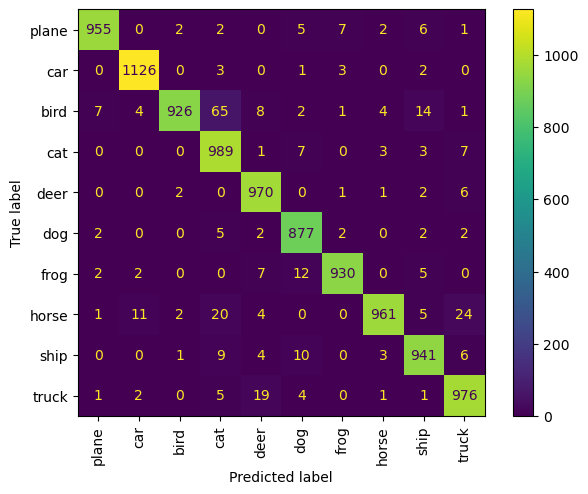

In [28]:
labels= ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
eval_model(model, test_loader, labels)

In [30]:
import torchsummary
torchsummary.summary(model, input_size=(1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
            Linear-2               [-1, 1, 256]          65,792
            Linear-3                [-1, 1, 10]           2,570
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.03
Estimated Total Size (MB): 1.03
----------------------------------------------------------------
